### Постановка задачи

**Цель исследования** придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд.

**Представленный датасет содержит**:
>- Относительная светимость L/Lo
>- Относительный радиус R/Ro
>- Абсолютная звёздная величина Mv
>- Звёздный цвет
>- Абсолютная температура T(K)

**План работ**:
>- Загрузка исходных данных
>- Исследовательский анализ
>- Подготовка данных к построению модели
>- Построение простой модели нейронной сети 
>- Улучшение сети

## Загрузка данных

In [1]:
!pip install phik

In [2]:
# загружаем основные данные
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

import phik
from phik.report import plot_correlation_matrix

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split


In [3]:
# загрузка датасета
data = pd.read_csv('/datasets/6_class.csv')
data.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


**Вывод:** В датасете 240 строчек, пропусков не обнаружено.

## Предобработка и анализ данных

In [5]:
# удалим на данный момент не нужную колонку
data_unnamed = data['Unnamed: 0']
data = data.drop('Unnamed: 0', axis = 1)
data

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,Blue
236,30839,834042.000000,1194.0000,-10.63,5,Blue
237,8829,537493.000000,1423.0000,-10.73,5,White
238,9235,404940.000000,1112.0000,-11.23,5,White


In [6]:
# переименуем колонки
data = data.rename(columns = {'Star type':'Star_type','Star color':'Star_color',
                              'Absolute magnitude(Mv)':'Absolute_magnitude(Mv)',
                             'Temperature (K)': 'Temperature(K)'})
data.head()

,Temperature(K),Luminosity(L/Lo),Radius(R/Ro),Absolute_magnitude(Mv),Star_type,Star_color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


In [7]:
# исследования стат. показателей
data.describe()

,Temperature(K),Luminosity(L/Lo),Radius(R/Ro),Absolute_magnitude(Mv),Star_type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


In [8]:
data.describe(include = object)

,Star_color
count,240
unique,19
top,Red
freq,112


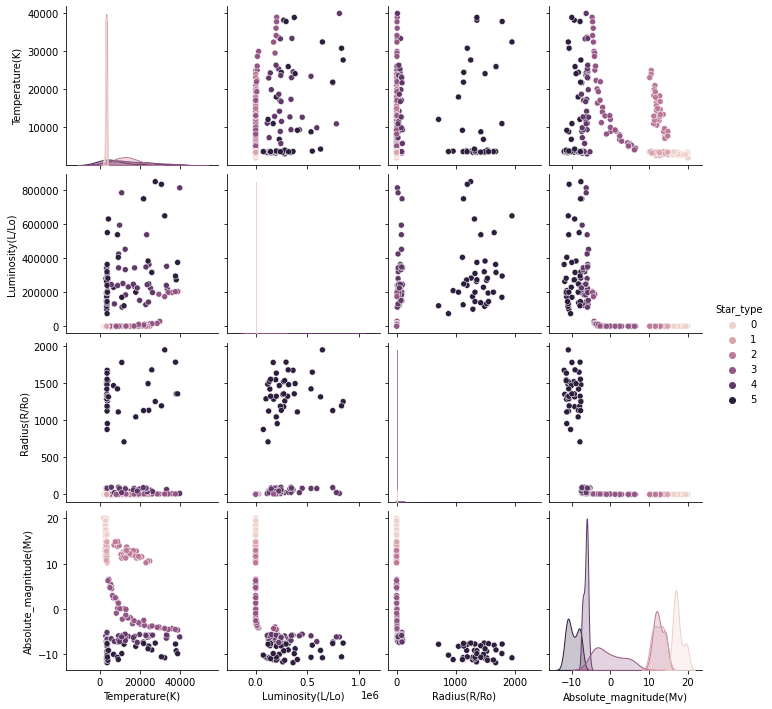

In [9]:
# матрица графиков 
sns.pairplot(data, hue='Star_type')
plt.show()

In [10]:
data_col = [x for x in data.columns]
data_col

['Temperature(K)',
 'Luminosity(L/Lo)',
 'Radius(R/Ro)',
 'Absolute_magnitude(Mv)',
 'Star_type',
 'Star_color']

<Figure size 720x576 with 0 Axes>

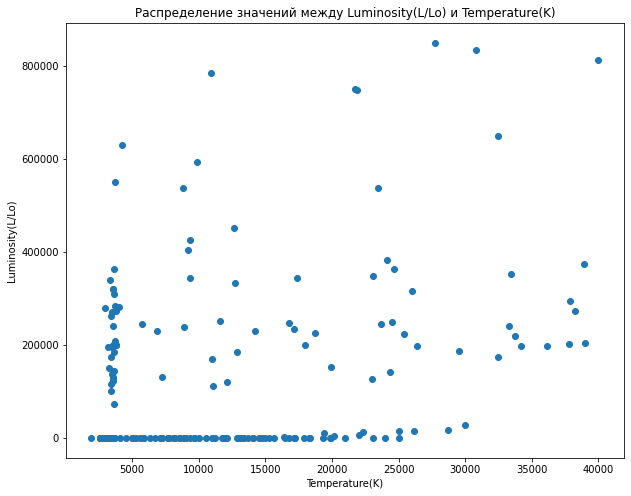

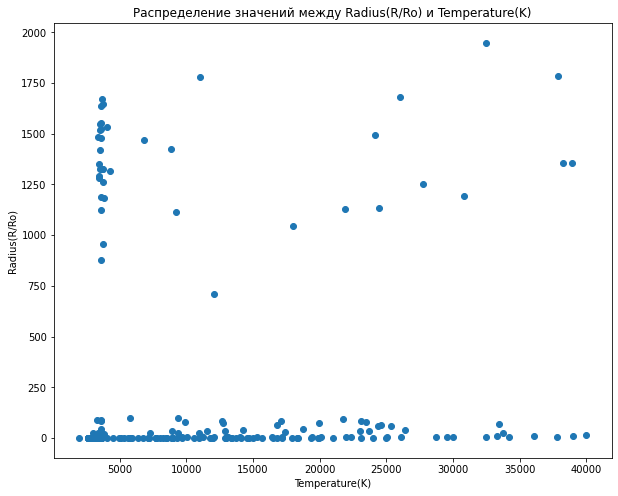

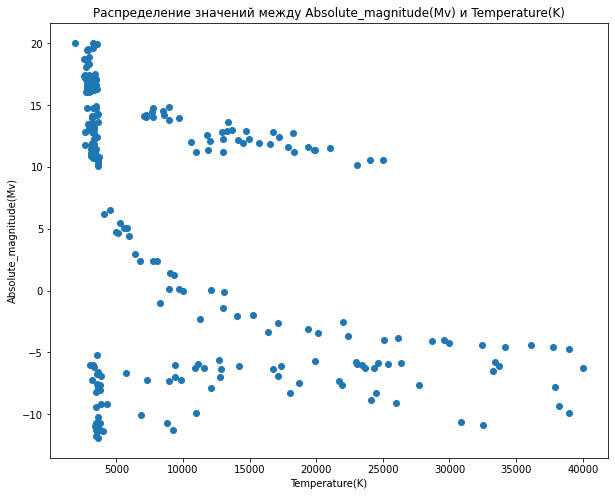

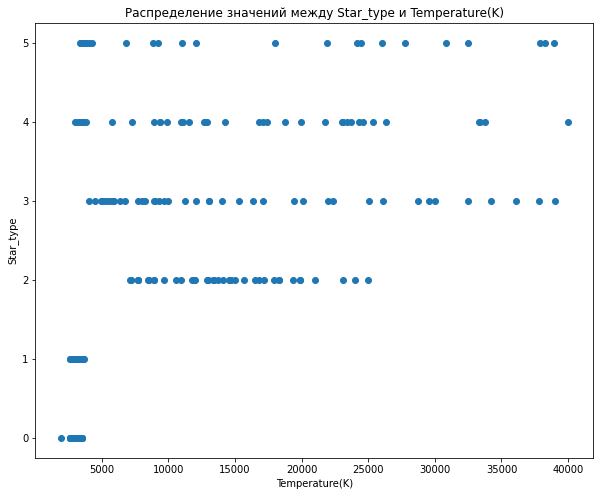

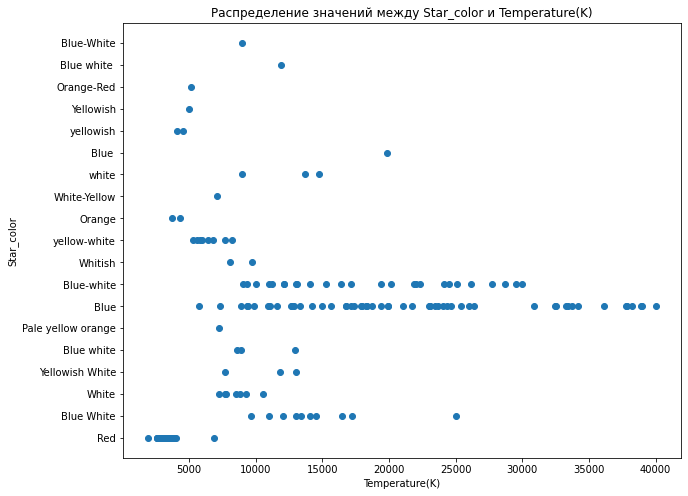

In [11]:
# изучение точечного распределения значений
for i in data_col:
    
    plt.figure(figsize=(10,8))
    
    if i == 'Temperature(K)': continue
    
    plt.scatter(data['Temperature(K)'], data[i])
    plt.title(f'Распределение значений между {i} и Temperature(K)')
    plt.xlabel('Temperature(K)')
    plt.ylabel(i)
    
    plt.show()
    

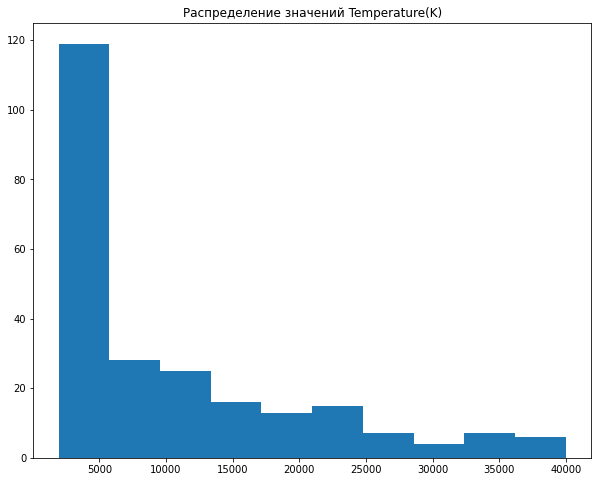

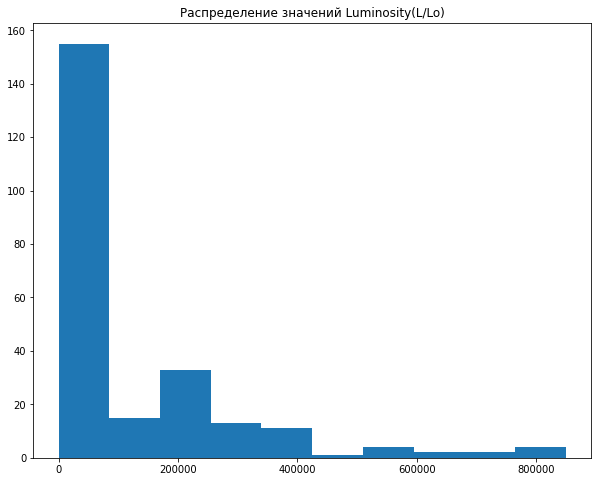

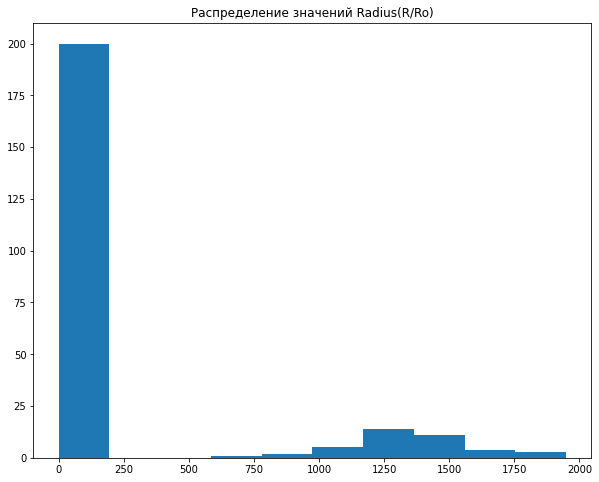

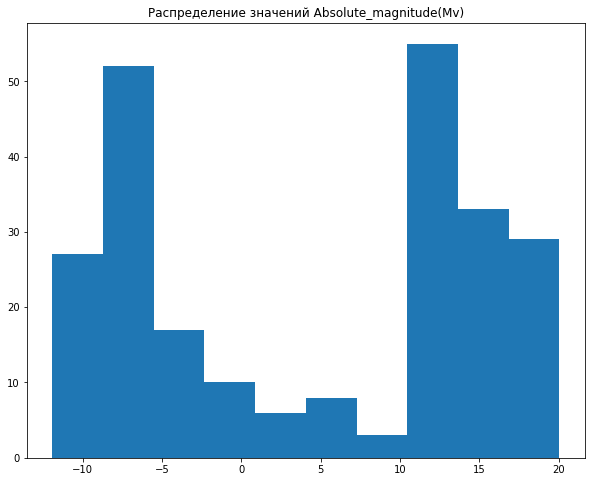

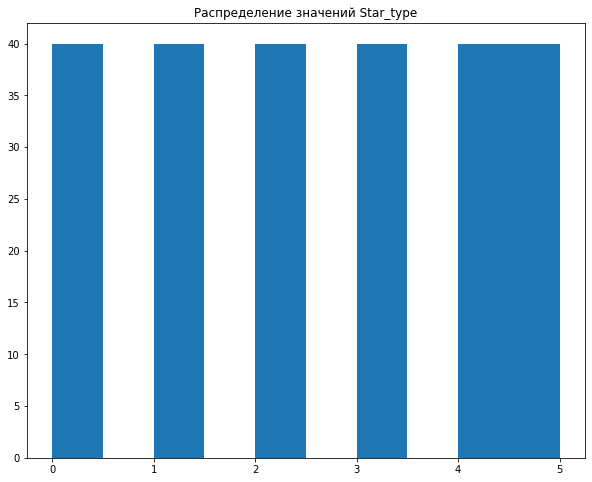

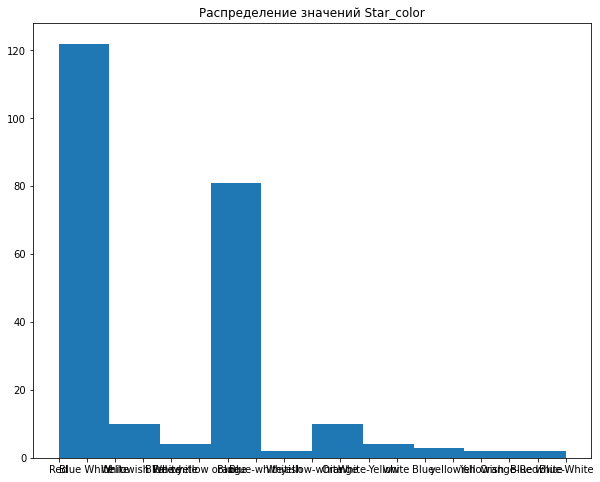

In [12]:
# изучение гистограмм распределения значений
for i in data_col:
    
    plt.figure(figsize=(10,8))
    
    plt.hist(data[i])
    plt.title(f'Распределение значений {i}')
    plt.show()

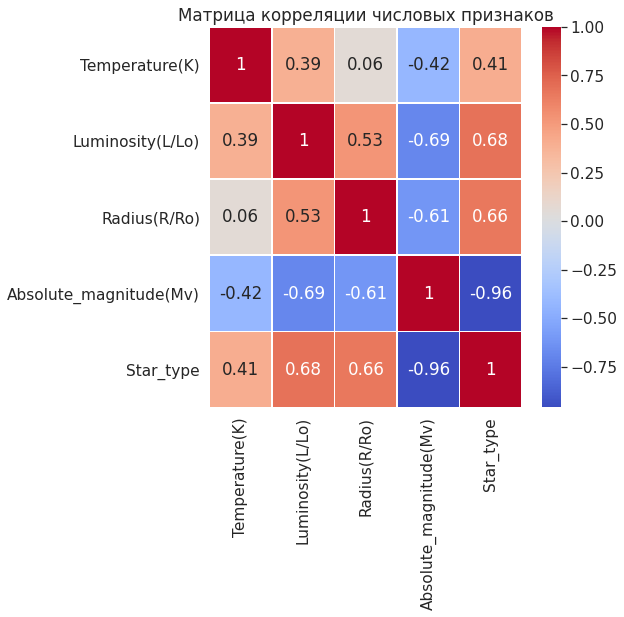

In [13]:

# тепловая карта
plt.figure(figsize = (7,7))
sns.set(font_scale = 1.4)
cor_matrix = round(data.corr(),2)
sns.heatmap(cor_matrix, annot = True, linewidths = .5, cmap = 'coolwarm')

plt.title("Матрица корреляции числовых признаков")
plt.show()

interval columns not set, guessing: ['Temperature(K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute_magnitude(Mv)', 'Star_type']


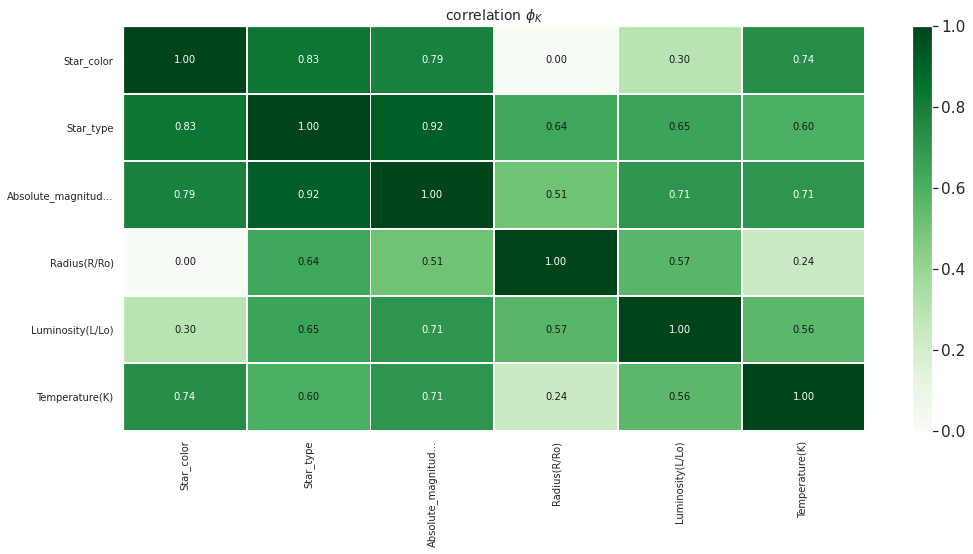

In [14]:
phik_overview = data.phik_matrix()

plot_correlation_matrix(phik_overview.values.round(2),
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=1,
                        figsize=(15, 8))
plt.tight_layout()

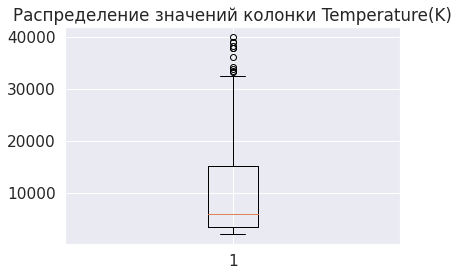

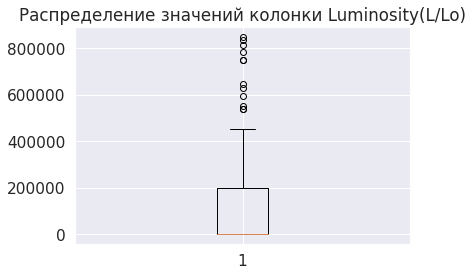

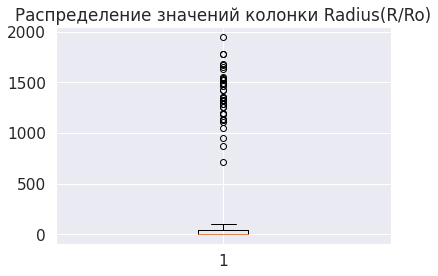

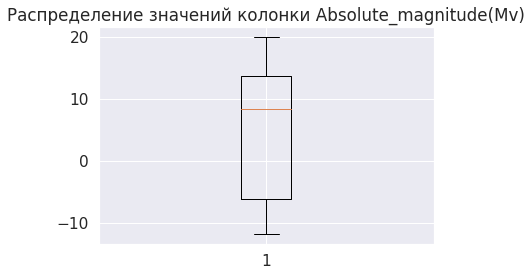

In [15]:
int_columns = data.select_dtypes(include=['int', 'float'])

for i in int_columns.columns:
    
    if i == 'Star_type': continue
    
    plt.boxplot(int_columns[i])
    plt.title(f'Распределение значений колонки {i}')
    plt.show()

**Вывод:** Было изучено распределение значений, замечено несколько значительных выбросов в данных, но т.к. датасет сильно ограничен то эти даннные оставим. С целевым признаком полностью не коррелирует радиус звезды. Значительная корреляция с целевым признаком присутствует у признаков Absolute_magnitude(Mv) и Star_color.

In [16]:
data['Star_color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

In [17]:
data['Star_color'] = data['Star_color'].str.strip()
data['Star_color'] = data['Star_color'].str.lower()

In [18]:
data['Star_color'] = data['Star_color'].str.replace('blue white', 'blue-white')

In [19]:
data['Star_color'].unique()

array(['red', 'blue-white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'whitish', 'yellow-white', 'orange',
       'white-yellow', 'yellowish', 'orange-red'], dtype=object)

In [20]:
# Подготовка различных датасетов для тестирования результатов модели
data_ohe = data.copy()

In [21]:
# деление выборки на тренировочную и тестовую
train, test = train_test_split(data_ohe, shuffle = True , test_size = 0.3, random_state = 12345)

In [22]:
# # колонки численных признаков
num_col = data.select_dtypes(include=['int', 'float']).columns.tolist()
num_col.remove('Star_type') 
num_col.remove('Temperature(K)') 

# колонки категориальных признаков
cat_cols = data.select_dtypes(include=['object']).columns.tolist()
cat_cols.append('Star_type')

# создаем и обучаем encoder
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
encoder_ohe.fit(train[cat_cols])

# трансформируем  train
train[encoder_ohe.get_feature_names()] = encoder_ohe.transform(train[cat_cols])

# удаляем старые колонки
train = train.drop(cat_cols, axis=1)

# трансформируем test
test[encoder_ohe.get_feature_names()] = encoder_ohe.transform(test[cat_cols])

# удаляем старые колонки
test = test.drop(cat_cols, axis=1)


/tmp/ipykernel_178/1909604941.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[encoder_ohe.get_feature_names()] = encoder_ohe.transform(train[cat_cols])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_178/1909604941.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [23]:
train.head()

,Temperature(K),Luminosity(L/Lo),Radius(R/Ro),Absolute_magnitude(Mv),x0_blue-white,x0_orange,x0_orange-red,x0_pale yellow orange,x0_red,x0_white,x0_white-yellow,x0_whitish,x0_yellow-white,x0_yellowish,x0_yellowish white,x1_1,x1_2,x1_3,x1_4,x1_5
165,7282,131000.000000,24.0000,-7.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
238,9235,404940.000000,1112.0000,-11.23,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
187,3484,0.000551,0.0998,16.67,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85,9675,0.000450,0.0109,13.98,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
162,12675,452000.000000,83.0000,-5.62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
test.head()

,Temperature(K),Luminosity(L/Lo),Radius(R/Ro),Absolute_magnitude(Mv),x0_blue-white,x0_orange,x0_orange-red,x0_pale yellow orange,x0_red,x0_white,x0_white-yellow,x0_whitish,x0_yellow-white,x0_yellowish,x0_yellowish white,x1_1,x1_2,x1_3,x1_4,x1_5
232,32489,648430.0,1948.50,-10.840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
30,39000,204000.0,10.60,-4.700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
216,9320,29.0,1.91,1.236,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
52,3834,272000.0,1183.00,-9.200,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
94,9030,45.0,2.63,1.450,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [25]:
#скалируем числовые колонки

scaler = StandardScaler()
train[num_col] = scaler.fit_transform(train[num_col])

test[num_col] = scaler.transform(test[num_col])



In [26]:
train.head()

,Temperature(K),Luminosity(L/Lo),Radius(R/Ro),Absolute_magnitude(Mv),x0_blue-white,x0_orange,x0_orange-red,x0_pale yellow orange,x0_red,x0_white,x0_white-yellow,x0_whitish,x0_yellow-white,x0_yellowish,x0_yellowish white,x1_1,x1_2,x1_3,x1_4,x1_5
165,7282,0.160953,-0.382081,-1.148865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
238,9235,1.736599,1.912754,-1.527235,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
187,3484,-0.592531,-0.432492,1.105313,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85,9675,-0.592531,-0.432680,0.851494,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
162,12675,2.007278,-0.257637,-0.997895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [27]:
test.head()

,Temperature(K),Luminosity(L/Lo),Radius(R/Ro),Absolute_magnitude(Mv),x0_blue-white,x0_orange,x0_orange-red,x0_pale yellow orange,x0_red,x0_white,x0_white-yellow,x0_whitish,x0_yellow-white,x0_yellowish,x0_yellowish white,x1_1,x1_2,x1_3,x1_4,x1_5
232,32489,3.137103,3.677119,-1.490436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
30,39000,0.580834,-0.410345,-0.911087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
216,9320,-0.592365,-0.428674,-0.350986,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
52,3834,0.971956,2.062509,-1.335691,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
94,9030,-0.592273,-0.427155,-0.330794,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [28]:
X_train = train.drop(['Temperature(K)'], axis = 1)
X_train = torch.FloatTensor(X_train.values)

y_train = train['Temperature(K)']
y_train = torch.FloatTensor(y_train.values)

In [29]:
X_test = test.drop(['Temperature(K)'], axis = 1)
X_test = torch.FloatTensor(X_test.values)

y_test = test['Temperature(K)']
y_test = torch.FloatTensor(y_test.values)

**Вывод:** Были исправлены опечатки в колонке Star_color, закодированы данные для дальнейшего обучения нейросети, подготовлены тестовые и тренировочные выборки.

## Построение базовой нейронной сети

Построение базовой нейросети

In [30]:
# базовая нейронная сеть
class Star_neuro(nn.Module):
    
    def __init__(self, n_in_neurons, n_out_neurons):
        super(Star_neuro, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_out_neurons) 
        
    def forward(self, x):
        
        out = self.fc1(x)

        return out

In [31]:
def Star_neuro_search(num_epochs, learning_rate, n_in_neurons = X_train.shape[1], n_out_neurons = 1):
    
    '''Функция для обучения и поиска лучших параметров нейросети'''
    
    torch.manual_seed(1234)
    
    model  = Star_neuro(n_in_neurons, n_out_neurons)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss = nn.MSELoss()

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        preds = model.forward(X_train).flatten()

        loss_value = loss(preds, y_train)

        loss_value.backward()

        optimizer.step()

        if epoch % 5000 == 0 or epoch == num_epochs - 1:

            print('Эпоха =',  epoch)

            model.eval()
            test_preds = model.forward(X_test).flatten()
            loss_value = loss(test_preds, y_test)

            print('RMSE = ', math.sqrt(loss_value.item()))

            print()
            
    return model

In [32]:
%%time
torch.manual_seed(1234)

num_epochs = 30000
learning_rate = 0.1

Star_neuro_search(num_epochs, learning_rate)


Эпоха = 0
RMSE =  15520.56803084217

Эпоха = 5000
RMSE =  14353.134849223705

Эпоха = 10000
RMSE =  13341.220933632723

Эпоха = 15000
RMSE =  12385.547706904204

Эпоха = 20000
RMSE =  11516.962446756523

Эпоха = 25000
RMSE =  10717.486272442806

Эпоха = 29999
RMSE =  10055.896578624901

CPU times: user 6.05 s, sys: 1.34 ms, total: 6.05 s
Wall time: 6.06 s


Star_neuro(
  (fc1): Linear(in_features=19, out_features=1, bias=True)
)

Добавим кол-во эпох т.к. модель ещё не переобучилась

In [33]:
%%time
torch.manual_seed(1234)

num_epochs = 100_000
learning_rate = 0.1

Star_neuro_search(num_epochs, learning_rate)


Эпоха = 0
RMSE =  15520.56803084217

Эпоха = 5000
RMSE =  14353.134849223705

Эпоха = 10000
RMSE =  13341.220933632723

Эпоха = 15000
RMSE =  12385.547706904204

Эпоха = 20000
RMSE =  11516.962446756523

Эпоха = 25000
RMSE =  10717.486272442806

Эпоха = 30000
RMSE =  10055.789576159597

Эпоха = 35000
RMSE =  9593.487791205032

Эпоха = 40000
RMSE =  9192.579616190442

Эпоха = 45000
RMSE =  8838.654648757354

Эпоха = 50000
RMSE =  8534.111787409396

Эпоха = 55000
RMSE =  8276.963694495706

Эпоха = 60000
RMSE =  8073.23850756312

Эпоха = 65000
RMSE =  7913.868838943441

Эпоха = 70000
RMSE =  7792.322118598538

Эпоха = 75000
RMSE =  7653.484435209887

Эпоха = 80000
RMSE =  7519.134790652446

Эпоха = 85000
RMSE =  7391.22804410742

Эпоха = 90000
RMSE =  7270.0789541792465

Эпоха = 95000
RMSE =  7157.407631258681

Эпоха = 99999
RMSE =  7053.314398210248

CPU times: user 20.1 s, sys: 12.6 ms, total: 20.1 s
Wall time: 20.2 s


Star_neuro(
  (fc1): Linear(in_features=19, out_features=1, bias=True)
)

Попробуем увеличить шаг обучения и добави ещё кол-ва эпох

In [34]:
%%time
torch.manual_seed(1234)

num_epochs = 150_000
learning_rate = 0.3

model = Star_neuro_search(num_epochs, learning_rate)

Эпоха = 0
RMSE =  15520.049484457193

Эпоха = 5000
RMSE =  12512.760207084606

Эпоха = 10000
RMSE =  10286.713372112592

Эпоха = 15000
RMSE =  8984.23597196779

Эпоха = 20000
RMSE =  8196.271347387177

Эпоха = 25000
RMSE =  7738.818256038838

Эпоха = 30000
RMSE =  7405.7275132157

Эпоха = 35000
RMSE =  7067.351979348417

Эпоха = 40000
RMSE =  6774.959778478394

Эпоха = 45000
RMSE =  6503.3286861421975

Эпоха = 50000
RMSE =  6264.811569392969

Эпоха = 55000
RMSE =  6063.187280630543

Эпоха = 60000
RMSE =  5899.3169096091115

Эпоха = 65000
RMSE =  5765.541431643693

Эпоха = 70000
RMSE =  5653.47008482401

Эпоха = 75000
RMSE =  5555.913066274526

Эпоха = 80000
RMSE =  5477.48464169458

Эпоха = 85000
RMSE =  5422.902912647432

Эпоха = 90000
RMSE =  5381.425833364239

Эпоха = 95000
RMSE =  5347.727928756286

Эпоха = 100000
RMSE =  5332.958090966026

Эпоха = 105000
RMSE =  5322.8225595073145

Эпоха = 110000
RMSE =  5315.150985625903

Эпоха = 115000
RMSE =  5312.919348155024

Эпоха = 120000
R

In [35]:
train_preds = model.forward(X_train).flatten()

loss = nn.MSELoss()
loss_value = loss(train_preds, y_train)

print('RMSE = ', math.sqrt(loss_value.item()))

RMSE =  4333.516355109324


In [36]:
test_preds = model.forward(X_test).flatten()

loss = nn.MSELoss()
loss_value = loss(test_preds, y_test)

print('RMSE = ', math.sqrt(loss_value.item()))

RMSE =  5312.918595273223


In [37]:
def data_to_hist(preds, true):
    
    data_back = {'y_true':true , 'y_pred': preds.detach().numpy()}
    data = pd.DataFrame(data_back)
    data['num_stur'] = data.index
    
    return data


In [38]:
data_train_pr = data_to_hist(train_preds, y_train)
data_train_pr.head()


,y_true,y_pred,num_stur
0,7282.0,18263.662109,0
1,9235.0,13969.903320,1
2,3484.0,3233.819824,2
3,9675.0,12688.431641,3
4,12675.0,20107.962891,4


In [39]:
data_test_pr = data_to_hist(test_preds, y_test)
data_test_pr.head()

,y_true,y_pred,num_stur
0,32489.0,32657.011719,0
1,39000.0,28055.625000,1
2,9320.0,18529.443359,2
3,3834.0,5193.586914,3
4,9030.0,18479.917969,4


In [40]:
def bar_chek(data, i):
    '''Строим гистограмму факт-прогноз'''
    
    plt.figure(figsize=(15,12))

    plt.bar(data['num_stur'], data['y_true'], color = 'b')
    plt.bar(data['num_stur'], data['y_pred'], color = 'y', width=0.6)
    
    
    plt.title(f'Гистограмма факт-прогноз выборки {i}')
    plt.legend(('Факт', 'Прогноз'))
    plt.xlabel('Номер звезды')
    plt.ylabel('Температура звезды')


    plt.show()

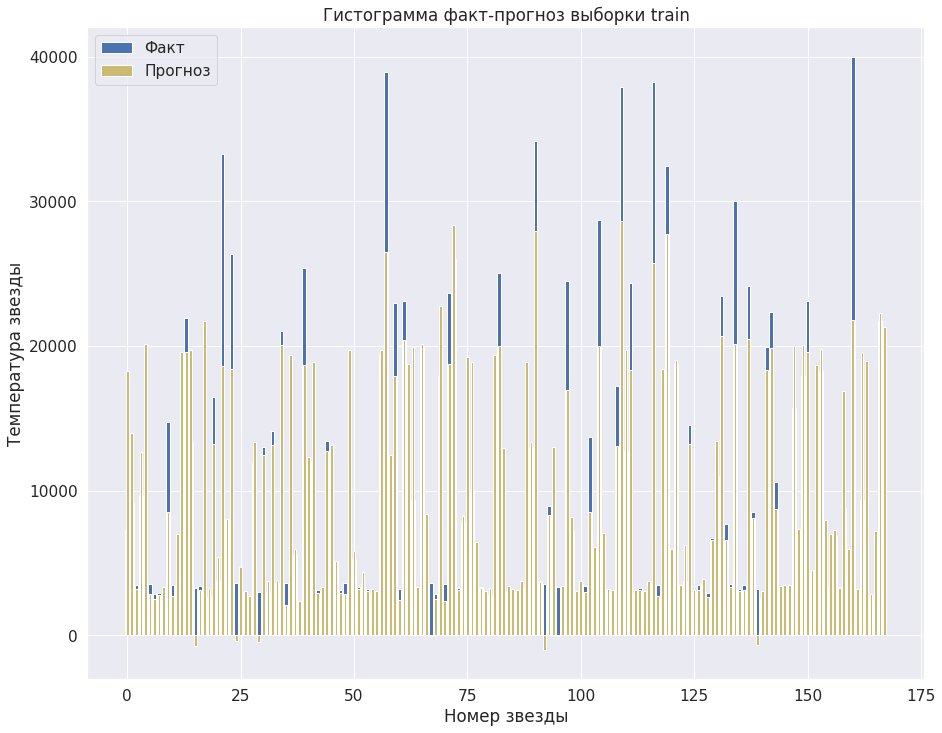

In [41]:
bar_chek(data_train_pr, 'train')

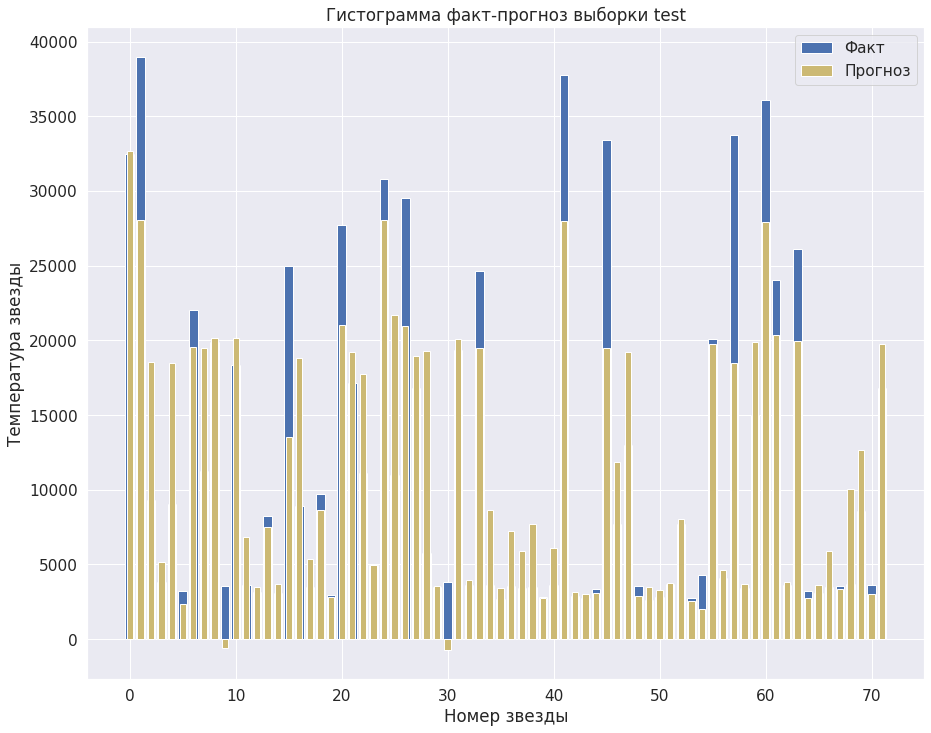

In [42]:
bar_chek(data_test_pr, 'test')

В данном варианте нейросети получилось добится метрики RMSE на тестовой выборке = 5312. Попробуем добавить ещё один слой.

In [43]:
# базовая нейронная сеть
class Star_neuro_2(nn.Module):
    
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_out_neurons):
        super(Star_neuro_2, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_out_neurons)
         
        
    def forward(self, x):
        
        out = self.fc1(x)
        out = self.relu1(out)
        
        out = self.fc2(out)
        
        return out

In [44]:
def Star_neuro_search(num_epochs, learning_rate, n_hidden_neurons_1, 
                      n_in_neurons = X_train.shape[1], n_out_neurons = 1):
    
    '''Функция для обучения и поиска лучших параметров нейросети'''
    
    torch.manual_seed(1234)
    
    model  = Star_neuro_2(n_in_neurons,n_hidden_neurons_1, n_out_neurons)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss = nn.MSELoss()

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        preds = model.forward(X_train).flatten()

        loss_value = loss(preds, y_train)

        loss_value.backward()

        optimizer.step()

        if epoch % 5000 == 0 or epoch == num_epochs - 1:

            print('Эпоха =',  epoch)

            model.eval()
            test_preds = model.forward(X_test).flatten()
            loss_value = loss(test_preds, y_test)

            print('RMSE = ', math.sqrt(loss_value.item()))

            print()
            
    return model

Т.к. это условно поиск базовой модели, кол-во нейронов буду выставлять вручную

In [45]:
%%time
torch.manual_seed(1234)

# параметры
n_hidden_neurons_1 = 16
num_epochs = 30_000
learning_rate = 0.1

Star_neuro_search(num_epochs, learning_rate, n_hidden_neurons_1)

Эпоха = 0
RMSE =  15519.930412215126

Эпоха = 5000
RMSE =  5739.014201062758

Эпоха = 10000
RMSE =  6192.524202617217

Эпоха = 15000
RMSE =  7186.395758653986

Эпоха = 20000
RMSE =  8501.684068465494

Эпоха = 25000
RMSE =  8891.446676441354

Эпоха = 29999
RMSE =  9416.3411153165

CPU times: user 54.3 s, sys: 48.8 ms, total: 54.4 s
Wall time: 54.6 s


Star_neuro_2(
  (fc1): Linear(in_features=19, out_features=16, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)

Для 1 скрытого слоя явно нужно меньше эпох, можно так же снизить рейт обучения

In [46]:
%%time
torch.manual_seed(1234)

# параметры
n_hidden_neurons_1 = 16
num_epochs = 10_000
learning_rate = 0.01

Star_neuro_search(num_epochs, learning_rate, n_hidden_neurons_1)

Эпоха = 0
RMSE =  15520.540712230357

Эпоха = 5000
RMSE =  5826.262609941299

Эпоха = 9999
RMSE =  5134.965822671072

CPU times: user 18.7 s, sys: 16.8 ms, total: 18.7 s
Wall time: 18.7 s


Star_neuro_2(
  (fc1): Linear(in_features=19, out_features=16, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)

Попробуем уменьшить количество нейронов в слое и увеличить кол-во эпох.

In [47]:
%%time
torch.manual_seed(1234)

# параметры
n_hidden_neurons_1 = 8
num_epochs = 17_000
learning_rate = 0.01

model = Star_neuro_search(num_epochs, learning_rate, n_hidden_neurons_1)

Эпоха = 0
RMSE =  15520.738642216742

Эпоха = 5000
RMSE =  7476.107810886625

Эпоха = 10000
RMSE =  5509.876042162836

Эпоха = 15000
RMSE =  5103.066529058778

Эпоха = 16999
RMSE =  5050.514429243817

CPU times: user 30.9 s, sys: 46.1 ms, total: 30.9 s
Wall time: 30.9 s


In [48]:
train_preds = model.forward(X_train).flatten()

loss = nn.MSELoss()
loss_value = loss(train_preds, y_train)

print('RMSE = ', math.sqrt(loss_value.item()))

RMSE =  3754.8065196491816


In [49]:
test_preds = model.forward(X_test).flatten()

loss = nn.MSELoss()
loss_value = loss(test_preds, y_test)

print('RMSE = ', math.sqrt(loss_value.item()))

RMSE =  5050.514429243817


In [50]:
data_train_pr = data_to_hist(train_preds, y_train) 
data_train_pr.head()


,y_true,y_pred,num_stur
0,7282.0,19155.888672,0
1,9235.0,10655.586914,1
2,3484.0,2827.646484,2
3,9675.0,11578.392578,3
4,12675.0,16327.141602,4


In [51]:
data_test_pr = data_to_hist(test_preds, y_test)
data_test_pr.head()

,y_true,y_pred,num_stur
0,32489.0,39372.570312,0
1,39000.0,30711.173828,1
2,9320.0,13808.708984,2
3,3834.0,3366.538086,3
4,9030.0,13506.195312,4


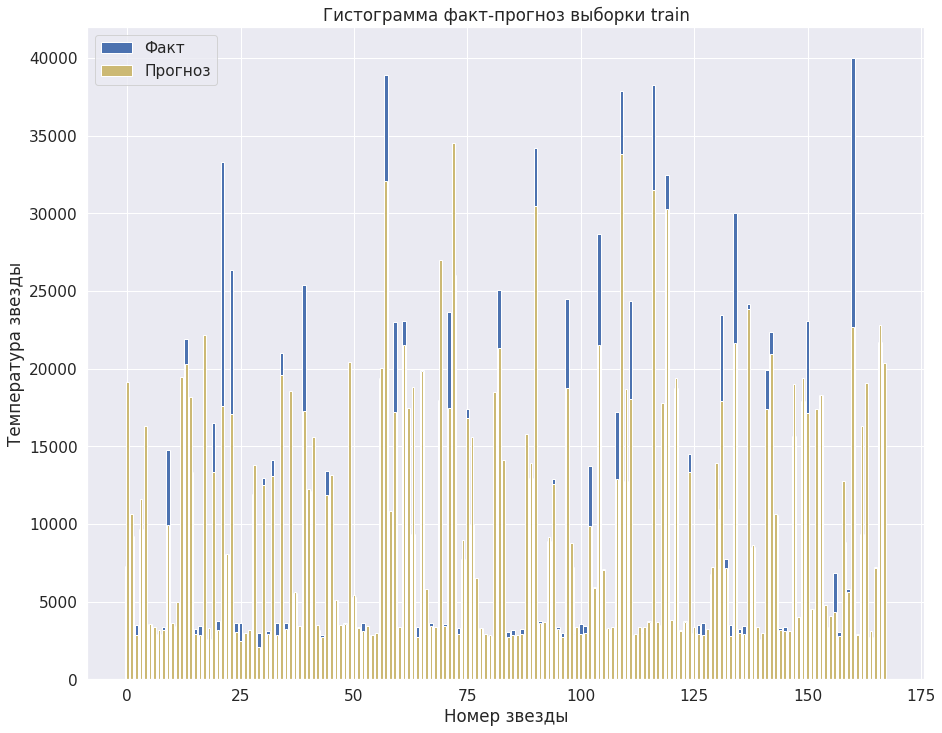

In [52]:
bar_chek(data_train_pr, 'train')

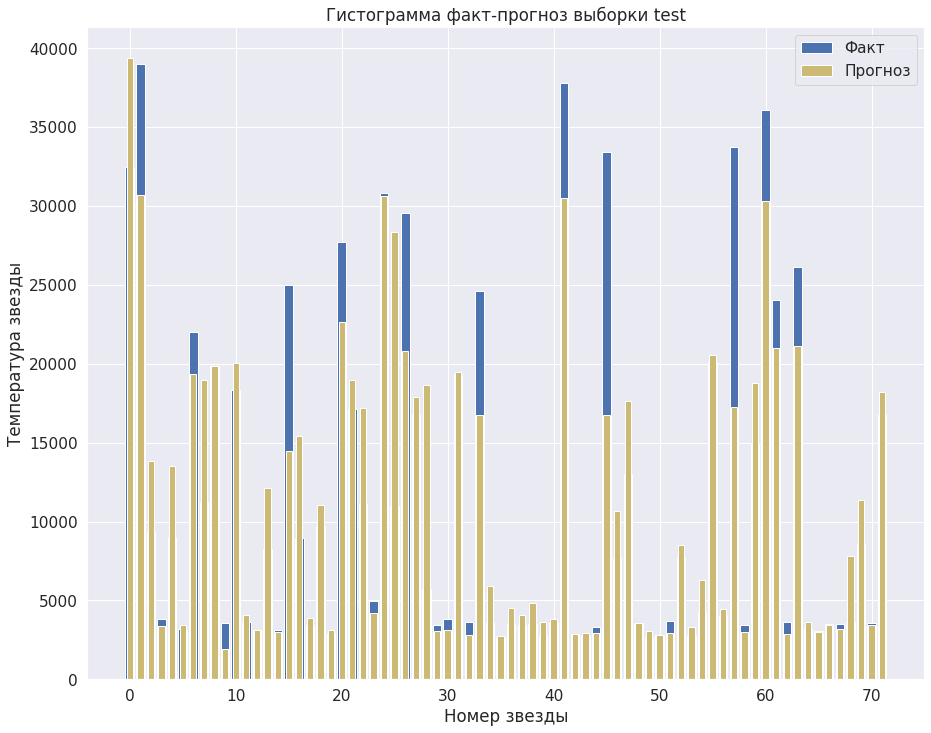

In [53]:
bar_chek(data_test_pr, 'test')

**Вывод:** При построении базовых сетей получилось добится метрики RMSE 5050 при использовании сети с 1 скрытым слоем. Возьмем данную сеть за базовую и попытаемся её улучшить. Так же видно, что сеть сильно достаточно заметно ошибается в предсказывании высоких температур звезд.

## Улучшение нейронной сети

Эксперементы с улучшением модели Star_neuro_2

Ранее лучшие параметры:

- n_hidden_neurons_1 = 8

- num_epochs = 17_000

- learning_rate = 0.01

### Эксперемент 1. Посмотрим на результат при изменении в лучшей модели функции активации

In [54]:
class Star_neuro_activate(nn.Module):
    
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_out_neurons):
        super(Star_neuro_2, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.tanh1 = nn.Tanh()
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_out_neurons)
         
        
    def forward(self, x):
        
        out = self.fc1(x)
        out = self.tanh1(out)
        
        out = self.fc2(out)
        
        return out

In [55]:
def Star_neuro_search(num_epochs, learning_rate, n_hidden_neurons_1,  
                      n_in_neurons = X_train.shape[1], n_out_neurons = 1):
    
    '''Функция для обучения и поиска лучших параметров нейросети'''
    
    torch.manual_seed(1234)
    
    model  = Star_neuro_2(n_in_neurons,n_hidden_neurons_1, n_out_neurons)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss = nn.MSELoss()

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        preds = model.forward(X_train).flatten()

        loss_value = loss(preds, y_train)

        loss_value.backward()

        optimizer.step()

        if epoch % 5000 == 0 or epoch == num_epochs - 1:

            print('Эпоха =',  epoch)

            model.eval()
            test_preds = model.forward(X_test).flatten()
            loss_value = loss(test_preds, y_test)

            print('RMSE = ', math.sqrt(loss_value.item()))

            print()
            
    return model

In [56]:
%%time
torch.manual_seed(1234)

# параметры
n_hidden_neurons_1 = 8
num_epochs = 17_000
learning_rate = 0.01

Star_neuro_search(num_epochs, learning_rate, n_hidden_neurons_1)

Эпоха = 0
RMSE =  15520.738642216742

Эпоха = 5000
RMSE =  7476.107810886625

Эпоха = 10000
RMSE =  5509.876042162836

Эпоха = 15000
RMSE =  5103.066529058778

Эпоха = 16999
RMSE =  5050.514429243817

CPU times: user 30.7 s, sys: 47.8 ms, total: 30.7 s
Wall time: 30.7 s


Star_neuro_2(
  (fc1): Linear(in_features=19, out_features=8, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)

Попробуем увеличить кол-во эпох

In [57]:
torch.manual_seed(1234)

# параметры
n_hidden_neurons_1 = 8
num_epochs = 30_000
learning_rate = 0.01

Star_neuro_search(num_epochs, learning_rate, n_hidden_neurons_1)

Эпоха = 0
RMSE =  15520.738642216742

Эпоха = 5000
RMSE =  7476.107810886625

Эпоха = 10000
RMSE =  5509.876042162836

Эпоха = 15000
RMSE =  5103.066529058778

Эпоха = 20000
RMSE =  5171.086732979829

Эпоха = 25000
RMSE =  5550.222518061776

Эпоха = 29999
RMSE =  5499.654352775272



Star_neuro_2(
  (fc1): Linear(in_features=19, out_features=8, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)

Попробуем увеличить кол-во слоев

In [58]:
torch.manual_seed(1234)

# параметры
n_hidden_neurons_1 = 16
num_epochs = 30_000
learning_rate = 0.01

Star_neuro_search(num_epochs, learning_rate, n_hidden_neurons_1)

Эпоха = 0
RMSE =  15520.540712230357

Эпоха = 5000
RMSE =  5826.262609941299

Эпоха = 10000
RMSE =  5134.917136624505

Эпоха = 15000
RMSE =  5238.1134008343115

Эпоха = 20000
RMSE =  5691.134333329341

Эпоха = 25000
RMSE =  5948.157361738171

Эпоха = 29999
RMSE =  6804.65135036322



Star_neuro_2(
  (fc1): Linear(in_features=19, out_features=16, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)

### Эксперемент 2. Добавим в класс nn.BatchNorm1d и найдем оптимальное кол-во нейронов в скрытом слое

In [59]:
class Star_neuro_batchnorm(nn.Module):
    
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_out_neurons):
        super(Star_neuro_batchnorm, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1) 
        self.relu1 = nn.Tanh()
        
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(n_hidden_neurons_1, n_out_neurons)  


    def forward(self, x):

        out = self.fc1(x)
        out = self.relu1(out)
        
        out = self.bn1(out)
        out = self.relu2(out)
        
        out = self.fc3(out)

        return out

In [60]:
def Star_neuro_search(num_epochs, learning_rate, n_hidden_neurons_1,  
                      n_in_neurons = X_train.shape[1], n_out_neurons = 1):
    
    '''Функция для обучения и поиска лучших параметров нейросети'''
    
    torch.manual_seed(1234)
    
    model  = Star_neuro_batchnorm(n_in_neurons, n_hidden_neurons_1, n_out_neurons)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss = nn.MSELoss()

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        preds = model.forward(X_train).flatten()

        loss_value = loss(preds, y_train)

        loss_value.backward()

        optimizer.step()

        if epoch % 5000 == 0 or epoch == num_epochs - 1:

            print('Эпоха =',  epoch)

            model.eval()
            test_preds = model.forward(X_test).flatten()
            loss_value = loss(test_preds, y_test)

            print('RMSE = ', math.sqrt(loss_value.item()))

            print()
            
    return model

In [61]:
%%time

torch.manual_seed(1234)

# параметры
n_hidden_neurons_1 = [2,4,8,16,32]
num_epochs = 15_000
learning_rate = [0.01, 0.1, 0.001]

for i in learning_rate:
    for x in n_hidden_neurons_1:
        print(f'исследование комбинации {x} нейронов при learning_rate {i}')
        
        Star_neuro_search(num_epochs, i, x)
        
        print('Исследование завершено')
        print()

исследование комбинации 2 нейронов при learning_rate 0.01
Эпоха = 0
RMSE =  15520.833998210277

Эпоха = 5000
RMSE =  10804.239168030297

Эпоха = 10000
RMSE =  6501.449684493451

Эпоха = 14999
RMSE =  6443.620721302582

Исследование завершено

исследование комбинации 4 нейронов при learning_rate 0.01
Эпоха = 0
RMSE =  15521.12521694223

Эпоха = 5000
RMSE =  10785.517697356952

Эпоха = 10000
RMSE =  8970.369000213983

Эпоха = 14999
RMSE =  8970.009587508812

Исследование завершено

исследование комбинации 8 нейронов при learning_rate 0.01
Эпоха = 0
RMSE =  15520.742250292027

Эпоха = 5000
RMSE =  6646.5281162423435

Эпоха = 10000
RMSE =  5434.912326799762

Эпоха = 14999
RMSE =  4593.933390897173

Исследование завершено

исследование комбинации 16 нейронов при learning_rate 0.01
Эпоха = 0
RMSE =  15520.563391836007

Эпоха = 5000
RMSE =  5883.948334239518

Эпоха = 10000
RMSE =  4655.702954442004

Эпоха = 14999
RMSE =  4684.73905356531

Исследование завершено

исследование комбинации 32 ней

learning_rate = 0.001 слишком маленькое значение для 15_000 эпох, необходимо увеличивать минимум до 100к. Попробуем подробней исследовать модель при комбинации 8 нейронов при learning_rate 0.01 и исследование комбинации 16 нейронов при learning_rate 0.01

In [62]:
def Star_neuro_search(num_epochs, learning_rate, n_hidden_neurons_1,  
                      n_in_neurons = X_train.shape[1], n_out_neurons = 1):
    
    '''Функция для обучения и поиска лучших параметров нейросети'''
    
    torch.manual_seed(1234)
    
    model  = Star_neuro_batchnorm(n_in_neurons, n_hidden_neurons_1, n_out_neurons)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss = nn.MSELoss()

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        preds = model.forward(X_train).flatten()

        loss_value = loss(preds, y_train)

        loss_value.backward()

        optimizer.step()

        if epoch % 1000 == 0 or epoch == num_epochs - 1:

            print('Эпоха =',  epoch)

            model.eval()
            test_preds = model.forward(X_test).flatten()
            loss_value = loss(test_preds, y_test)

            print('RMSE = ', math.sqrt(loss_value.item()))

            print()
            
    return model

In [63]:
%%time
torch.manual_seed(1234)

# параметры
n_hidden_neurons_1 = 8
num_epochs = 20_000
learning_rate = 0.01

Star_neuro_search(num_epochs, learning_rate, n_hidden_neurons_1)

Эпоха = 0
RMSE =  15520.742250292027

Эпоха = 1000
RMSE =  14148.839669739706

Эпоха = 2000
RMSE =  11616.496545860977

Эпоха = 3000
RMSE =  9645.555660510181

Эпоха = 4000
RMSE =  8022.770344463313

Эпоха = 5000
RMSE =  6646.5281162423435

Эпоха = 6000
RMSE =  6054.13577647545

Эпоха = 7000
RMSE =  5622.982660474777

Эпоха = 8000
RMSE =  5320.5048632625085

Эпоха = 9000
RMSE =  5365.665103228117

Эпоха = 10000
RMSE =  5434.912326799762

Эпоха = 11000
RMSE =  5015.838912883865

Эпоха = 12000
RMSE =  4585.1647734841545

Эпоха = 13000
RMSE =  4609.80823896179

Эпоха = 14000
RMSE =  4605.86756214288

Эпоха = 15000
RMSE =  4593.4588275067845

Эпоха = 16000
RMSE =  4600.681905978721

Эпоха = 17000
RMSE =  4629.33839765468

Эпоха = 18000
RMSE =  4644.6816898470015

Эпоха = 19000
RMSE =  4643.928509354983

Эпоха = 19999
RMSE =  4641.765827785801

CPU times: user 52.5 s, sys: 156 ms, total: 52.7 s
Wall time: 52.9 s


Star_neuro_batchnorm(
  (fc1): Linear(in_features=19, out_features=8, bias=True)
  (relu1): Tanh()
  (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)

In [64]:
%%time
torch.manual_seed(1234)

# параметры
n_hidden_neurons_1 = 16
num_epochs = 20_000
learning_rate = 0.01

Star_neuro_search(num_epochs, learning_rate, n_hidden_neurons_1)

Эпоха = 0
RMSE =  15520.563391836007

Эпоха = 1000
RMSE =  11978.623627111756

Эпоха = 2000
RMSE =  8592.535830591572

Эпоха = 3000
RMSE =  7398.079480513845

Эпоха = 4000
RMSE =  6765.729228989289

Эпоха = 5000
RMSE =  5883.948334239518

Эпоха = 6000
RMSE =  5313.058064805993

Эпоха = 7000
RMSE =  4911.986156332284

Эпоха = 8000
RMSE =  4711.470895590887

Эпоха = 9000
RMSE =  4512.568005027736

Эпоха = 10000
RMSE =  4655.702954442004

Эпоха = 11000
RMSE =  4603.335095341203

Эпоха = 12000
RMSE =  4656.249348993243

Эпоха = 13000
RMSE =  4646.892725252004

Эпоха = 14000
RMSE =  4610.845258735105

Эпоха = 15000
RMSE =  4685.113018914271

Эпоха = 16000
RMSE =  4686.231748430715

Эпоха = 17000
RMSE =  4682.819449861376

Эпоха = 18000
RMSE =  4677.135020501332

Эпоха = 19000
RMSE =  4674.298663970885

Эпоха = 19999
RMSE =  4674.013264850668

CPU times: user 54.9 s, sys: 200 ms, total: 55.1 s
Wall time: 55.2 s


Star_neuro_batchnorm(
  (fc1): Linear(in_features=19, out_features=16, bias=True)
  (relu1): Tanh()
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)

### Эксперемент 3. Попробуем вместо nn.BatchNorm1d применить nn.Dropout

In [65]:
class Star_neuro_dropout(nn.Module):
    
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_out_neurons):
        super(Star_neuro_dropout, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1) 
        self.relu1 = nn.ReLU()
        
        self.dp1 = nn.Dropout(p=0.5)
        
        self.fc3 = nn.Linear(n_hidden_neurons_1, n_out_neurons)  


    def forward(self, x):

        out = self.fc1(x)
        out = self.relu1(out)
        
        out = self.dp1(out)
        
        out = self.fc3(out)

        return out

In [66]:
def Star_neuro_search(num_epochs, learning_rate, n_hidden_neurons_1,  
                      n_in_neurons = X_train.shape[1], n_out_neurons = 1):
    
    '''Функция для обучения и поиска лучших параметров нейросети'''
    
    torch.manual_seed(1234)
    
    model  = Star_neuro_dropout(n_in_neurons, n_hidden_neurons_1, n_out_neurons)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss = nn.MSELoss()

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        preds = model.forward(X_train).flatten()

        loss_value = loss(preds, y_train)

        loss_value.backward()

        optimizer.step()

        if epoch % 1000 == 0 or epoch == num_epochs - 1:

            print('Эпоха =',  epoch)

            model.eval()
            test_preds = model.forward(X_test).flatten()
            loss_value = loss(test_preds, y_test)

            print('RMSE = ', math.sqrt(loss_value.item()))

            print()
            
    return model

In [67]:
%%time
torch.manual_seed(1234)

# параметры
n_hidden_neurons_1 = 8
num_epochs = 20_000
learning_rate = 0.01

Star_neuro_search(num_epochs, learning_rate, n_hidden_neurons_1)

Эпоха = 0
RMSE =  15520.738642216742

Эпоха = 1000
RMSE =  13460.231795923872

Эпоха = 2000
RMSE =  10399.939999826922

Эпоха = 3000
RMSE =  8551.037363969357

Эпоха = 4000
RMSE =  7890.1475271378795

Эпоха = 5000
RMSE =  7476.299351952141

Эпоха = 6000
RMSE =  7056.218817468744

Эпоха = 7000
RMSE =  6584.708042123052

Эпоха = 8000
RMSE =  6114.8995085773895

Эпоха = 9000
RMSE =  5712.322820009387

Эпоха = 10000
RMSE =  5509.717234123726

Эпоха = 11000
RMSE =  5301.9967936617995

Эпоха = 12000
RMSE =  5148.156951764388

Эпоха = 13000
RMSE =  5090.136343949934

Эпоха = 14000
RMSE =  5101.033620747858

Эпоха = 15000
RMSE =  5102.7126119349505

Эпоха = 16000
RMSE =  5077.018810286209

Эпоха = 17000
RMSE =  5050.29642694367

Эпоха = 18000
RMSE =  5062.576024120527

Эпоха = 19000
RMSE =  5106.440443205031

Эпоха = 19999
RMSE =  5164.105343619551

CPU times: user 38.8 s, sys: 98.6 ms, total: 38.9 s
Wall time: 39 s


Star_neuro_dropout(
  (fc1): Linear(in_features=19, out_features=8, bias=True)
  (relu1): ReLU()
  (dp1): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)

In [68]:
%%time
torch.manual_seed(1234)

# параметры
n_hidden_neurons_1 = 16
num_epochs = 20_000
learning_rate = 0.01

Star_neuro_search(num_epochs, learning_rate, n_hidden_neurons_1)

Эпоха = 0
RMSE =  15520.540712230357

Эпоха = 1000
RMSE =  10397.84400729305

Эпоха = 2000
RMSE =  7904.805626958831

Эпоха = 3000
RMSE =  7193.589090294218

Эпоха = 4000
RMSE =  6474.99745173695

Эпоха = 5000
RMSE =  5826.273594674387

Эпоха = 6000
RMSE =  5520.765164359013

Эпоха = 7000
RMSE =  5318.5404012755225

Эпоха = 8000
RMSE =  5220.639041343502

Эпоха = 9000
RMSE =  5212.9306536726535

Эпоха = 10000
RMSE =  5195.447622678916

Эпоха = 11000
RMSE =  5199.57709818789

Эпоха = 12000
RMSE =  5207.139905936848

Эпоха = 13000
RMSE =  5113.471423602561

Эпоха = 14000
RMSE =  5080.381284903723

Эпоха = 15000
RMSE =  5118.577341410404

Эпоха = 16000
RMSE =  5183.19824046891

Эпоха = 17000
RMSE =  5224.510886197865

Эпоха = 18000
RMSE =  5272.576220406871

Эпоха = 19000
RMSE =  5349.391554186326

Эпоха = 19999
RMSE =  5444.09882349687

CPU times: user 37.7 s, sys: 62.6 ms, total: 37.8 s
Wall time: 38.2 s


Star_neuro_dropout(
  (fc1): Linear(in_features=19, out_features=16, bias=True)
  (relu1): ReLU()
  (dp1): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)

Dropout явно хуже BatchNorm1d, остановимся на 2 варианте.

### Эксперемент 4. Попробуем отойти от кол-ва слоев равного степени двойки на всё техже 2вух моделях

In [69]:
class Star_neuro_search_len(nn.Module):
    
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_out_neurons):
        super(Star_neuro_search_len, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1) 
        self.relu1 = nn.Tanh()
        
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(n_hidden_neurons_1, n_out_neurons)  


    def forward(self, x):

        out = self.fc1(x)
        out = self.relu1(out)
        
        out = self.bn1(out)
        out = self.relu2(out)
        
        out = self.fc3(out)

        return out

In [70]:
def Star_neuro_search(num_epochs, learning_rate, n_hidden_neurons_1,  
                      n_in_neurons = X_train.shape[1], n_out_neurons = 1):
    
    '''Функция для обучения и поиска лучших параметров нейросети'''
    
    torch.manual_seed(1234)
    
    model  = Star_neuro_search_len(n_in_neurons, n_hidden_neurons_1, n_out_neurons)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss = nn.MSELoss()

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        preds = model.forward(X_train).flatten()

        loss_value = loss(preds, y_train)

        loss_value.backward()

        optimizer.step()

        if epoch % 1000 == 0 or epoch == num_epochs - 1:

            print('Эпоха =',  epoch)

            model.eval()
            test_preds = model.forward(X_test).flatten()
            loss_value = loss(test_preds, y_test)

            print('RMSE = ', math.sqrt(loss_value.item()))

            print()
            
    return model

In [71]:
%%time
torch.manual_seed(1234)

# параметры
n_hidden_neurons_1 = [8,9,10,11,12,13,14,15,16,17]
num_epochs = 30_000
learning_rate = 0.01

for x in n_hidden_neurons_1:
    print(f'исследование кол-ва слоев {x}')
    Star_neuro_search(num_epochs, learning_rate, x)
    print()

исследование кол-ва слоев 8
Эпоха = 0
RMSE =  15520.742250292027

Эпоха = 1000
RMSE =  14148.839669739706

Эпоха = 2000
RMSE =  11616.496545860977

Эпоха = 3000
RMSE =  9645.555660510181

Эпоха = 4000
RMSE =  8022.770344463313

Эпоха = 5000
RMSE =  6646.5281162423435

Эпоха = 6000
RMSE =  6054.13577647545

Эпоха = 7000
RMSE =  5622.982660474777

Эпоха = 8000
RMSE =  5320.5048632625085

Эпоха = 9000
RMSE =  5365.665103228117

Эпоха = 10000
RMSE =  5434.912326799762

Эпоха = 11000
RMSE =  5015.838912883865

Эпоха = 12000
RMSE =  4585.1647734841545

Эпоха = 13000
RMSE =  4609.80823896179

Эпоха = 14000
RMSE =  4605.86756214288

Эпоха = 15000
RMSE =  4593.4588275067845

Эпоха = 16000
RMSE =  4600.681905978721

Эпоха = 17000
RMSE =  4629.33839765468

Эпоха = 18000
RMSE =  4644.6816898470015

Эпоха = 19000
RMSE =  4643.928509354983

Эпоха = 20000
RMSE =  4641.566115009028

Эпоха = 21000
RMSE =  4646.2834610040745

Эпоха = 22000
RMSE =  4645.871070100849

Эпоха = 23000
RMSE =  4701.9340701460

**Успех**, найдены параметры для модели которые переходят порог RMSE 4500

### Лучшая модель

In [72]:
%%time
torch.manual_seed(1234)

# параметры
n_hidden_neurons_1 = 9
num_epochs = 18000
learning_rate = 0.01

model = Star_neuro_search(num_epochs, learning_rate, n_hidden_neurons_1)


Эпоха = 0
RMSE =  15520.79637132064

Эпоха = 1000
RMSE =  13576.782534901264

Эпоха = 2000
RMSE =  10499.699805232529

Эпоха = 3000
RMSE =  9084.402897273987

Эпоха = 4000
RMSE =  8691.341438466216

Эпоха = 5000
RMSE =  6992.613531434438

Эпоха = 6000
RMSE =  6274.750353599735

Эпоха = 7000
RMSE =  5876.751483600442

Эпоха = 8000
RMSE =  5093.265357312536

Эпоха = 9000
RMSE =  5105.200485779183

Эпоха = 10000
RMSE =  5021.222759448141

Эпоха = 11000
RMSE =  4992.590509945713

Эпоха = 12000
RMSE =  4987.683430210863

Эпоха = 13000
RMSE =  4980.5090101313945

Эпоха = 14000
RMSE =  4830.221734040789

Эпоха = 15000
RMSE =  4552.6442865657755

Эпоха = 16000
RMSE =  4397.917461708439

Эпоха = 17000
RMSE =  4338.700035724986

Эпоха = 17999
RMSE =  4267.971180783676

CPU times: user 49.2 s, sys: 126 ms, total: 49.4 s
Wall time: 49.4 s


In [73]:
train_preds = model.forward(X_train).flatten()

loss = nn.MSELoss()
loss_value = loss(train_preds, y_train)

print('RMSE = ', math.sqrt(loss_value.item()))


RMSE =  3387.53789646699


In [74]:
test_preds = model.forward(X_test).flatten()

loss = nn.MSELoss()
loss_value = loss(test_preds, y_test)

print('RMSE = ', math.sqrt(loss_value.item()))

RMSE =  4267.971180783676


In [75]:
data_train_pr = data_to_hist(train_preds, y_train) 
data_train_pr.head()

,y_true,y_pred,num_stur
0,7282.0,18965.023438,0
1,9235.0,8971.302734,1
2,3484.0,3018.654297,2
3,9675.0,11498.616211,3
4,12675.0,18965.308594,4


In [76]:
data_test_pr = data_to_hist(test_preds, y_test)
data_test_pr.head()

,y_true,y_pred,num_stur
0,32489.0,28931.785156,0
1,39000.0,28931.781250,1
2,9320.0,10634.676758,2
3,3834.0,3739.965820,3
4,9030.0,10485.476562,4


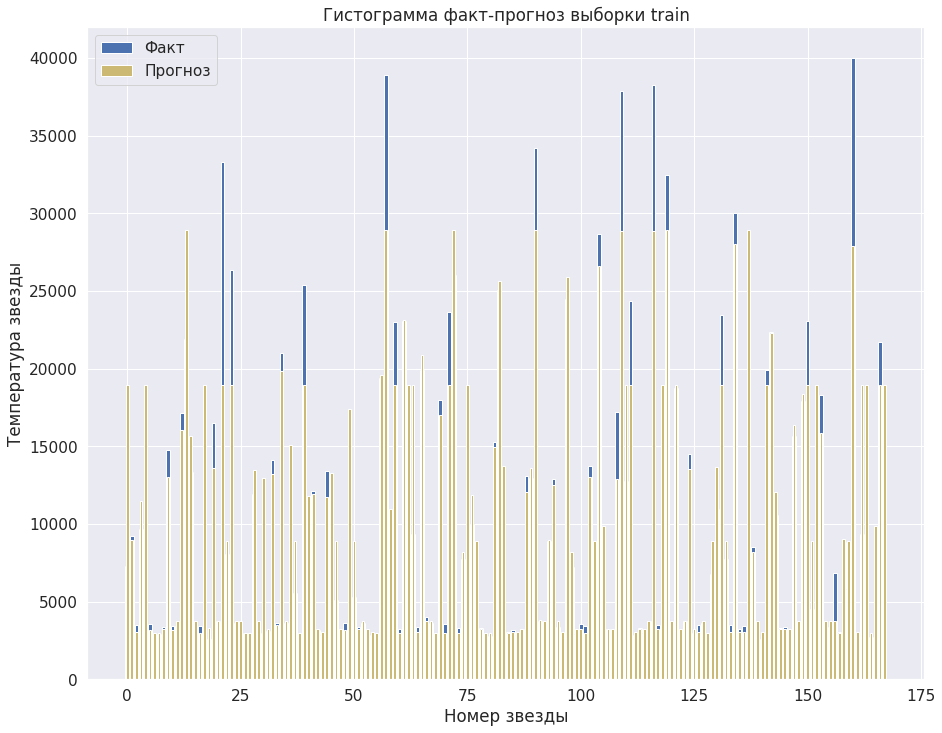

In [77]:
bar_chek(data_train_pr, 'train')

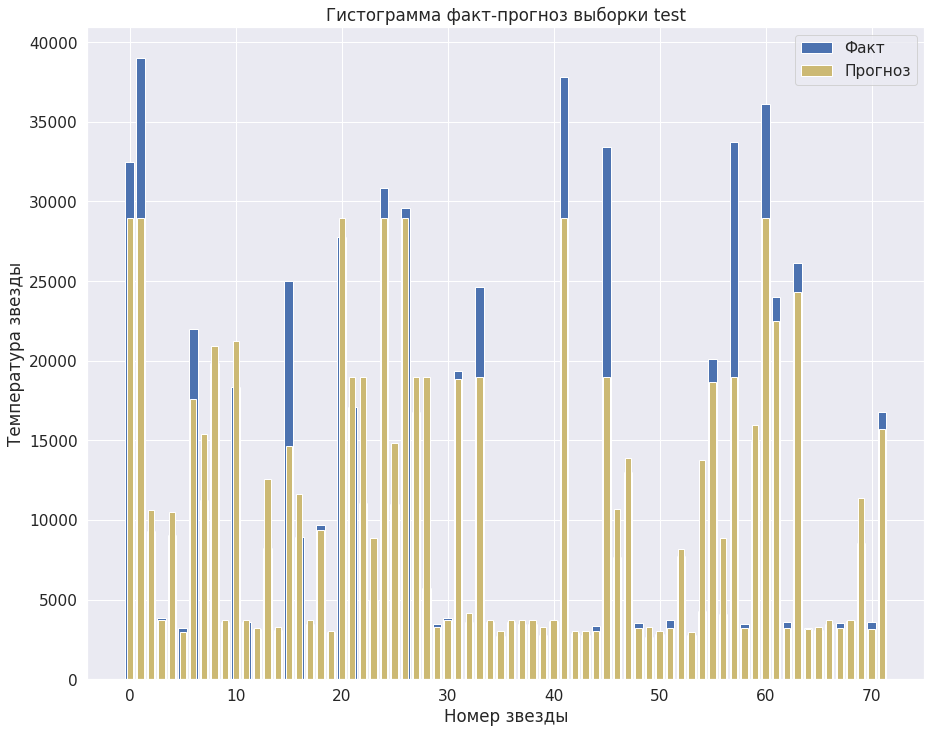

In [78]:
bar_chek(data_test_pr, 'test')

Улучшим модель добавив нормализацию батчей и сменим функцию активации на первом слое, увеличим кол-во эпох

**Вывод:** Была подобрана оптимальные параметры для нейронной сети. При изучении результатов предсказания выявлено что модель в большинстве своём часто ошибается в предсказании значений для звезд, чья температура выше 5000 Кельвинов.

## Выводы

<div style="border:solid steelgreen 4px; padding: 20px; border-radius: 15px">
<h1>Итог:</h1>

>В ходе работы были выполнены следующие операции:
>>- Изучена общая информация о представленном датасете
>>- Изучены данные в предоставленных датасетах
>>- Подготовка датасета для обучения нейронной сети
>>- Подобраны лучшие параметры для нейронной сети
>>- Изучены результаты предсказания


> В ходе исследования была подобраны лучшие параметры для нейросети. Результат её предсказывания на тестовой выборке показывает ошибку RMSE равную 4267. По графикам результатов предсказывания видно, что модель относительно хорошо предсказывает температуру звезд до 5000 Кельвинов, но есть значительные ошибки при предсказании температур звезд выше этого значения. Возможно есть некоторые условия, которые не были учтены в данных.